# Developer's tutorial

## Purpose

XXX

## Set up

XXX

## Content

- Write a scratch code 
- Turn that into SimPEG classes

# Write a scratch code

In [94]:
# define a time mesh
from discretize import TensorMesh
from numpy.polynomial import polynomial

nt = 1000
ht = np.ones(nt) * 0.001
time_mesh = TensorMesh([ht], x0=[0.])

# define measuring points (receiver)
measured_times = np.array([0.053, 0.214, 0.435, 0.898, 0.923])

# define a linear interpolation matrix to evaluate data at measured times. 
# dimension of a matrix, Pt, is [size of the field x size of the data]
Pt = time_mesh.get_interpolation_matrix(measured_times, location_type='N')

# model is a vector containing coefficents of the 1D polynomial
# Example: Evaluate f(t) = 2t^3 - 5t^2 + 3t - 7
m = [2, -5, 3, -7]
time_nodes = time_mesh.nodes_x
fields = polynomial.polyval(time_nodes, m)
data = Pt * fields

def func(m, x):
    return m[3]*x**3 + m[2]*x**2 + m[1]*x + m[0]

Text(0, 0.5, 'Geophysical data')

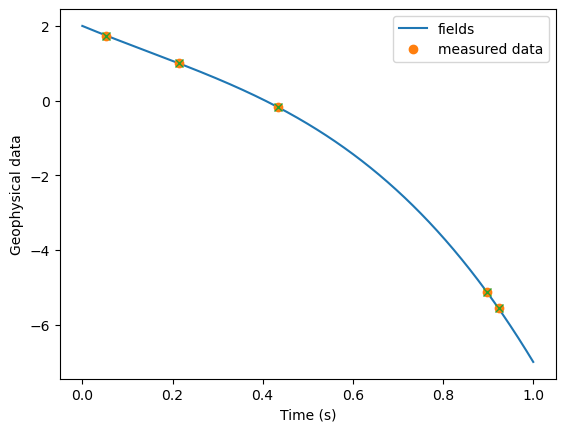

In [95]:
import matplotlib.pyplot as plt
plt.plot(time_nodes, fields, label='fields')
plt.plot(measured_times, data, 'o', label='measured data')
plt.plot(measured_times, func(m, measured_times), 'x')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Geophysical data")

In [103]:
# calculate derivatives

# caculate derivatives for fields
dfields_dm = polynomial.polyvander(time_nodes, len(m)-1)

# evaluate derivatives on the measured times; this is often referred to a Jacobian Matrix
dd_dm = Pt @ dfields_dm

We finished progamming a scratch code that can calculate forward response and its sensitivity function. Let's put togehter these scratch codes into SimPEG classes. 

- `Simulation` class
- `Survey` class
- `Source` class
- `Receiver` class


# Turn scratch codes into SimPEG classes 

## `Simulation` class

In [9]:
from SimPEG.simulation import BaseSimulation
from SimPEG import props

In [125]:
class PolynomialSimulation(BaseSimulation):
    """
    Class for a geophysical simulation of the form

    .. math::

        d = F[m]

    where :math:`d` is a vector of the data, `F` is a polynomial function takes 
    a model, `m`, (i.e., polynomial coefficients) and outputs the data. 
    :math:`m` is the model.
    """

    poly_model, poly_map, poly_deriv = props.Invertible(
        "The model for a polynomial problem"
    )

    def __init__(self, mesh=None, poly_model=None, poly_map=None, **kwargs):
        super().__init__(mesh=mesh, **kwargs)
        self.poly_model = poly_model
        self.poly_map = poly_map
        self.solver = None

    def fields(self, m):
        self.model = m
        f = polynomial.polyval(self.mesh.nodes_x, m)
        return f

    def dpred(self, m=None, f=None):
        
        self.model = m
        
        if f is None:
            f = self.fields(m)            
        # Assume a single source
        src = self.survey.source_list[0]
        # Assume a single receiver
        rx = src.receiver_list[0]
        data = rx.getP(self.mesh, 'nodes') @ f
        return data

    def Jvec(self, m, v, f=None):
        self.model = m        
        # caculate derivatives for fields
        dfields_dm = polynomial.polyvander(self.mesh.nodes_x, len(m)-1)
        # evaluate derivatives on the measured times; this is often referred to a Jacobian Matrix
        J = rx.getP(self.mesh, 'nodes') @ dfields_dm                
        return J @ v

    def Jtvec(self, m, v, f=None):
        self.model = m        
        # caculate derivatives for fields
        dfields_dm = polynomial.polyvander(self.mesh.nodes_x, len(m)-1)
        # evaluate derivatives on the measured times; this is often referred to a Jacobian Matrix
        J = rx.getP(self.mesh, 'nodes') @ dfields_dm                
        return J.T @ v

In [129]:
from SimPEG.survey import BaseSrc, BaseRx, BaseSurvey
from SimPEG.maps import IdentityMap

In [135]:
receiver = BaseRx(locations=measured_times.reshape([-1,1]))
receiver_list = [receiver]
source = BaseSrc(receiver_list=receiver_list)
source_list = [source]
survey = BaseSurvey(source_list)
simulation = PolynomialSimulation(mesh=time_mesh, survey=survey, poly_map=IdentityMap(nP=len(m)))

In [136]:
simulation.dpred(m)

array([ 1.74238486,  0.99878559, -0.18351512, -5.13984354, -5.56352627])